<h1 align="center">AIND-CNC Spring Hackathon</h1>  
<h4 align="center"> May 14, 2025 </h4>   
<h4 align="center"> Credit Assignment During Learning</h4> 
    

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
**Overview:** This notebook shows how to access and analyze data from the [Credit Assignment During Learning](https://www.allenneuraldynamics.org/projects/credit-assignment-during-learning) project established at the Allen Institute for Neural Dynamics. 

**Dataset:** Calcium activity was recorded from hundreds of neurons in mouse motor cortex while the animal learned and performed a Brain Computer Interface (BCI) task over several days. During the task, the activity of a single neuron in layer 2/3 of primary motor cortex was used to control the movement of a reward lickport closer to the animal. To probe causal connectivity changes after learning, two-photon optogenetics was paired with calcium imaging to activate single neurons in the imaging field of view and record output responses in the local network. 
    
**Goal:** This tutorial will show you how to: <br> 
    1. load and work with neuronal calcium activity data processed via suite2p <br> 
    2. plot event-aligned neural activity traces <br>


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Import packages and load data

In [1]:
# General imports 
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats 
import os 
import re
import pandas as pd
from skimage import measure
from pathlib import Path
from cycler import cycler 

# Pynwb imports
from hdmf_zarr import NWBZarrIO
from nwbwidgets import nwb2widget

# Custom functions
from generate_epoch_table import generate_epoch_table

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Metadata

The 'metadata.csv' in the '/data' folder contains relevant information about the experimental session and the subject. 

| Column    | Description |
| -------- | ------- |
| name | filename of data asset (raw) |
| subject_id| numerical id for animal subject  |
| session_time |  experiment date (%Y-%m-%d %H:%M:%S)   |
| session_type   |  experiment identifier  |
| genotype  | subject genotype   |
| virus   | injected virus type  |
| session_number    | behavior training session number   |

In [72]:
# Load csv as a Pandas DataFrame 
metadata = pd.read_csv('/data/metadata.csv', index_col = False) 

# Sort values by name and reindex 
metadata = metadata.sort_values(by = ['name']).reset_index(drop = True)
metadata[0:5]

,_id,name,subject_id,session_time,session_type,genotype,virus_injection_materials,ophys_fov,session_number
0,e19d57eb-048c-49fb-a564-9f23b3205c3d,single-plane-ophys_731015_2025-01-24_20-00-44_...,731015,2025-01-24T18:41:22.550000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_04,20.0
1,5c307543-bf11-4a82-bcdf-85f0886d41cb,single-plane-ophys_731015_2025-01-28_17-40-57_...,731015,2025-01-28T17:40:57.996000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_04,22.0
2,0b6a3ab2-c50c-429a-9588-1e6992ded444,single-plane-ophys_731015_2025-01-28_18-56-35_...,731015,2025-01-28T17:40:57.996000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_04,22.0
3,57178d7b-5c87-4376-933a-769eeabcdd19,single-plane-ophys_731015_2025-01-31_20-37-19_...,731015,2025-01-31T20:37:19.623000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_04,23.0
4,d69eda23-6aa2-4904-80aa-53f44feb534c,single-plane-ophys_740369_2025-01-09_17-18-37_...,740369,2025-01-09T16:01:04.455000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_05,22.0


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

This file was pre-generated by running the metadata python notebook attached to this capsule. More metadata was captured for each experimental session than what is shown here - you can access the full records by querying the AIND metadata database using `aind-data-access-api`. See the metadata python notebook for an example. 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Data Organization 
    
The naming scheme for each raw data asset is as follows:
 > single-plane-ophys (data type) <br> 
   772414 (numerical id for the subject) <br> 
   2025-01-10T16:46:51.981999-08:00 (experiment date (%Y-%m-%d %H:%M:%S)) <br>
    
The /data folder contains a directory named for each experimental session that was processed through the optical physiology (ophys) pipeline (e.g. `single-plane-ophys_731015_2025-01-24_20-00-44_processed_2025-05-07_12-19-25`). The pipeline runs the raw fluorescence data through suite2p and packages the ophys, behavior, and stimulus information into an Neurodata Without Borders (NWB) format. Each directory contains an NWB directory (e.g. `single-plane-ophys_731015_2025-01-24_20-00-44_behavior_nwb`).
    
From the metadata table, we'll store the subject_id and date for a session of interest. 

In [20]:
idx = 0

subject_id = metadata.subject_id[idx] 
date = metadata.session_time[idx][0:10] # save just the year, month, and date

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Load Data 
    
These NWB files are stored in a cloud-friendly Zarr backend. We'll use the NWBZarrIO package from hdmf_zarr to load the files. 
    
We've written a helper function `load_nwb` that searches the /data folder for an NWB directory that matches a given subject_id and date, then loads using NWBZarrIO. 
    

In [21]:
def load_nwb(subject_id, date):
    """
    Searches the /data directory for a folder and subfolder containing the subject_id and date,
    and loads the corresponding NWB file.

    Parameters:
    - subject_id (str): Subject identifier to search for in directory names
    - date (str): Date string (e.g. '2023-05-09') to search for in directory names

    Returns:
    - nwbfile: Loaded NWBFile object if found, else None
    """

    # Create pattern for matching
    pattern = rf".*{subject_id}.*{date}.*"
    base_path = Path('/data')
    
    # Find matching first-level directories
    first_matches = [d for d in base_path.iterdir() 
                     if d.is_dir() and re.search(pattern, d.name)]
    
    if not first_matches:
        print(f"Directory matching subject_id={subject_id} and date={date} not found in /data.")
        return None
    
    first_dir = first_matches[0]
    print(f"Found first-level directory: {first_dir.name}")
    
    # Find matching second-level directories
    second_matches = [d for d in first_dir.iterdir() 
                      if d.is_dir() and re.search(pattern, d.name)]
    
    if not second_matches:
        print(f"No second-level directory matching subject_id={subject_id} and date={date} found.")
        return None
    
    nwb_path = second_matches[0]
    print(f"Found second-level directory: {nwb_path.name}")
    
    # Check if path exists and load NWB file
    try:
        with NWBZarrIO(str(nwb_path), 'r') as io:
            nwbfile = io.read()
            print('Loaded NWB file from:', nwb_path)
            return nwbfile
    except Exception as e:
        print(f'Error loading file from {nwb_path}: {e}')
        return None

In [22]:
nwbfile = load_nwb(subject_id, date)

Found first-level directory: single-plane-ophys_731015_2025-01-24_20-00-44_processed_2025-05-10_22-05-27
Found second-level directory: single-plane-ophys_731015_2025-01-24_20-00-44_behavior_nwb
Loaded NWB file from: /data/single-plane-ophys_731015_2025-01-24_20-00-44_processed_2025-05-10_22-05-27/single-plane-ophys_731015_2025-01-24_20-00-44_behavior_nwb


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

`nwb2widget` creates an interactive widget to easily explore the hierarchical contents of the NWB file. The widget can also render interactive data plots (e.g. calcium activity traces, image segmentation masks). 

In [23]:
nwb2widget(nwbfile) 


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Plot Calcium Activity Traces for Select ROIs 
    
The raw fluorescence data was processed through suite2p, which segments the images into ROIS for detected neurons and calculates the change in fluorescence (dff) for each ROI. Let's store the dff data from the NWB file below. The shape of dff is nframes x nrois. 
    
We'll also store the frame_rate to easily convert from frames to seconds.
    

In [24]:
dff = nwbfile.processing["processed"].data_interfaces["dff"].roi_response_series["dff"].data

print('dff shape:',np.shape(dff))

frame_rate = nwbfile.imaging_planes["processed"].imaging_rate
print('Frame Rate:', frame_rate)

dff shape: (232140, 385)
Frame Rate: 58.2634


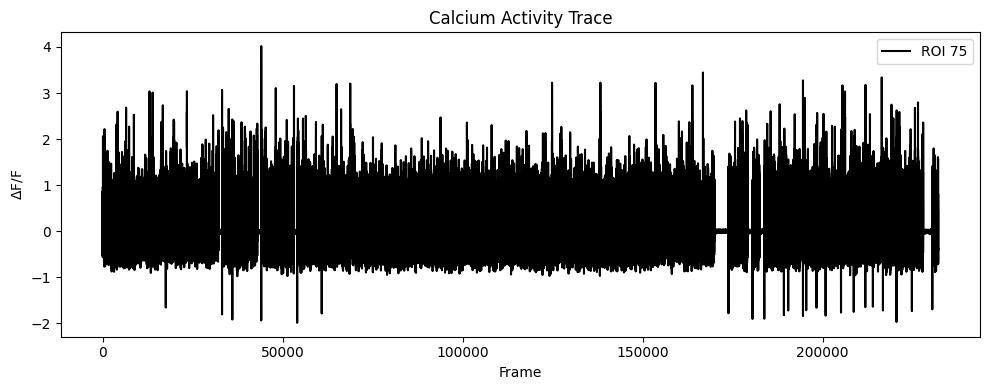

In [59]:
# Select an ROI 
ROI = 75

# Figure parameters 
plt.rcParams["figure.figsize"] = (10, 4)

plt.plot(dff[:, ROI], label=f'ROI {ROI}', color='black')

plt.ylabel(r'$\Delta$F/F')
plt.xlabel('Frame')
plt.title('Calcium Activity Trace')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Experiment Structure 
    
The dff array covers the entire experimental period, which has 5 experimental epochs. 

    1. Photostimulation of single neurons * 
    2. Spontaneous activity *
    3. BCI behavior task 
    4. Spontaneous activity * 
    5. Photostimulation of single neurons * 
    
*In some cases, the spontaneous epoch happens before the photostimulation period. Check the stimulus tables for each data file to get the exact timing order of each epoch. 

The NWB file contains information about the stimulus and the behavior trials.  


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Stimulus table (2p optogenetic activation stimulus) 
    
The stimulus table (stimulus > PhotostimTrials) contains information about each 2p optogenetic stimulation trial. 


| Column    | Description |
| -------- | ------- |
| start_time  | stimulus start (s)  |
| stop_time | stimulus end (s)   |
| start_frame | stimulus start (frame)     |
| stop_frame    | stimulus end (frame)  |
| tiff_file   | data source file name  |
| stim_name    | stimulus name   |
| laser_stim_x    | x coordinate of stimulated neuron (pixel)   |
| laser_stim_y    | y coordinate of stimulated neuron (pixel)  |
| power    | stimulus intensity (mW)  |
| duration    | trial duration (s)  |
| stimulus_function    | stimulus template   |
| group_index    | identity of stimulated neuron(s)*    |

*note that this number does not correspond to the image segmentation ROI index

In [55]:
photostim = nwbfile.stimulus["PhotostimTrials"].to_dataframe()
photostim[0:5]


,start_time,stop_time,start_frame,stop_frame,tiff_file,stim_name,laser_stim_x,laser_stim_y,power,duration,stimulus_function,group_index
id,,,,,,,,,,,,
0,0.000000,1.132787,0,66,spont_slm_00001.tif,photostim,165.567568,196.108108,4,1.132787,scanimage.mroi.stimulusfunctions.logspiral,21
1,1.149950,2.282737,67,133,spont_slm_00002.tif,photostim,58.403226,197.983871,4,1.132787,scanimage.mroi.stimulusfunctions.logspiral,22
2,2.299900,3.415523,134,199,spont_slm_00003.tif,photostim,94.828125,75.828125,4,1.115623,scanimage.mroi.stimulusfunctions.logspiral,4
3,3.432687,4.513983,200,263,spont_slm_00004.tif,photostim,358.895833,193.479167,4,1.081296,scanimage.mroi.stimulusfunctions.logspiral,26
4,4.531146,5.629606,264,328,spont_slm_00005.tif,photostim,87.287879,189.833333,4,1.098460,scanimage.mroi.stimulusfunctions.logspiral,14


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

There are two photostimulation epochs - one before and one after the BCI epoch. This is distinguished by the "stim_name" column. 

In [56]:
photostim.stim_name.unique()

array(['photostim', 'photostim_post'], dtype=object)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### BCI Behavior Table 
    
Information about the BCI behavior trials can be found in the intervals > trials table. 

| Column    | Description |
| -------- | ------- |
| start_time  | trial start (s)  |
| stop_time | trial end (s)   |
| BCI_go_cue |  time of go cue relative to start time (s)   |
| BCI_trial_hit   |  boolean of whether trial was hit   |
| BCI_lick_l  | lick times (s)   |
| BCI_reward_time   | reward delivery time (s)   |
| BCI_threshold_crossing_times    | time when reward port crossed position threshold (s)   |
| BCI_zaber_steps   | position of reward port  |
| BCI_movie_name    | data source file  |
| start_frame    | trial start (frame)  |
| stop_frame    | trial end (frame)  |
| conditioned_neuron_x    | coordinate for conditioned neuron (pixels)  |
| conditioned_neuron_y    | coordinate for conditioned neuron (pixels)  |


In [57]:
bci = nwbfile.intervals["trials"].to_dataframe()
bci[0:5]

,start_time,stop_time,BCI_go_cue,BCI_trial_hit,BCI_lick_L,BCI_reward_time,BCI_threshold_crossing_times,BCI_zaber_steps,BCI_movie_name,start_frame,stop_frame,conditioned_neuron_x,conditioned_neuron_y
id,,,,,,,,,,,,,
0,1393.379034,1398.699698,0.2359,True,"[1.4923000000000002, 1.6292, 1.7521, 1.8716, 1...",1.4923,1.4402,"[0.5722, 0.7792, 0.9072, 0.9882, 1.0602, 1.138...",neuron53_00001.tif,81183,81493,38.166667,44.166667
1,1398.716862,1404.260651,0.2359,True,"[2.2792, 2.4113, 2.5264, 2.6327000000000003, 2...",2.2792,2.1610,"[1.1298, 1.6857, 1.7597, 1.8227, 1.8717, 1.905...",neuron53_00002.tif,81494,81817,38.166667,44.166667
2,1404.277814,1409.546988,0.2359,True,"[1.6492, 1.7715, 1.8798, 1.9924, 2.1023, 2.216...",1.6492,1.5602,"[1.0237, 1.1028, 1.1527, 1.1997, 1.2397, 1.271...",neuron53_00003.tif,81818,82125,38.166667,44.166667
3,1409.564152,1413.923664,0.2359,True,"[0.0222, 0.9292, 1.0387, 1.1985, 1.3162, 1.437...",1.0387,1.0308,"[0.2863, 0.3373, 0.3833, 0.4243, 0.4653, 0.505...",neuron53_00004.tif,82126,82380,38.166667,44.166667
4,1413.940827,1418.471974,0.2359,True,"[1.1341, 1.2667000000000002, 1.404, 1.5119, 1....",1.2667,1.1805,"[0.3632, 0.6332, 0.7482000000000001, 0.8282, 0...",neuron53_00005.tif,82381,82645,38.166667,44.166667


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Epoch Table 
    
We've written a helper function `generate_epoch_table` that will aggregate the start/end frames and times from the stimulus table and the behavior table from the nwb file. This generates a table with the start and stop times for each experimental epoch, so we can easily pull these values for later use. 


In [35]:
help(generate_epoch_table)

Help on function generate_epoch_table in module generate_epoch_table:

generate_epoch_table(nwbfile)
    Finds frame and time ranges for photostim, photostim_post, behavior, spontaneous, and spontaneous_post epochs from the photostim and behavior tables in the NWB files 
    
    Parameters:
    - nwbfile: NWBFile object
    
    Returns:
    - epoch_table: pandas.DataFrame of epoch frame and time ranges



In [37]:
epoch_table = generate_epoch_table(nwbfile)

epoch_table

,stim_name,start_frame,stop_frame,start_time,stop_time
1,photostim,0,69481,0.000000,1192.532533
3,spont,69482,81182,1192.549697,1393.361870
0,BCI,81183,134768,1393.379034,2313.081626
4,spont_post,134769,147111,2313.098789,2524.929887
2,photostim_post,147112,232139,2524.947051,3984.302324


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Plot calcium activity for a select ROI with stimulus epochs overlaid. 


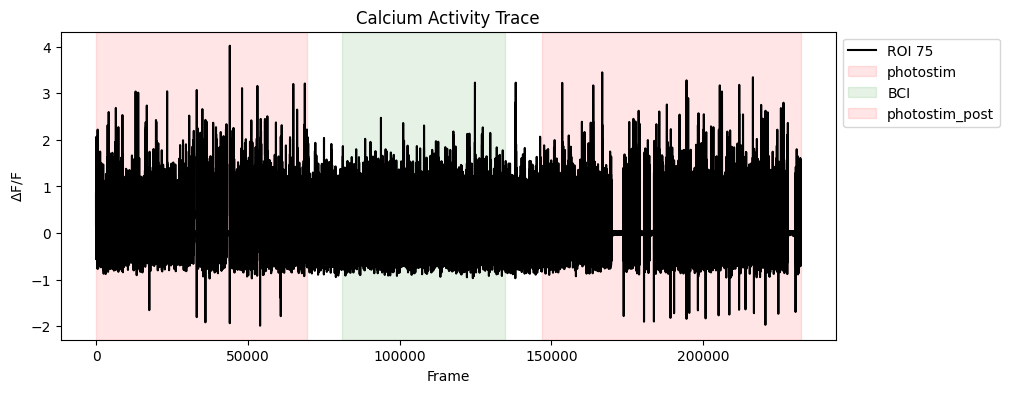

In [60]:
# Plot dff for select ROI 
plt.rcParams["figure.figsize"] = (10, 4)

plt.plot(dff[:, ROI], label=f'ROI {ROI}', color='black')

# Add shaded regions for stimulus epochs 
stim_names = ['photostim','BCI','photostim_post']
colors = ['red','green','red']
for c,stim_name in enumerate(stim_names):
    stim = epoch_table[epoch_table.stim_name==stim_name]
    for j in range(len(stim)):
        plt.axvspan(xmin=stim.start_frame.iloc[j], xmax=stim.stop_frame.iloc[j], color=colors[c], alpha=0.1, label = stim_name)

plt.ylabel(r'$\Delta$F/F')
plt.xlabel('Frame')
plt.title('Calcium Activity Trace')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Image Segmentation Table 
    
Each column in dff contains change in fluorescence activity for an extracted ROI. The raw fluorescence data is run through suite2p, which segments the image to extract image masks for each detected ROI. The suite2p outputs are run through additional soma and dendrite classifiers. Information about the spatial image masks and soma/dendrite can be found in the image segmentation table within the processing container. 
    
We'll store the image segmentation table as a Pandas DataFrame. 

| Column    | Description |
| -------- | ------- |
| is_soma  | ==1 if ROI classified as soma, ==0 if not  |
| soma_probability | if >0.5 classified as soma  |
| is_dendrite |  ==1 if ROI classified as dendrite, ==0 if not   |
| dendrite_probability   |  if >0.5 classified as dendrite  |
| image_mask  | HxW sparse array defining image masks|

In [61]:
image_segmentation = nwbfile.processing["processed"].data_interfaces["image_segmentation"].plane_segmentations["roi_table"].to_dataframe()
image_segmentation[0:5]

,is_soma,soma_probability,is_dendrite,dendrite_probability,image_mask
id,,,,,
0,1,0.698195,0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1,0.999978,0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,1,0.998079,0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,1,0.994994,0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,1,1.000000,0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### ROI Image Masks 
    
The image masks for each ROI are necessary for corresponding the ROIs to the photostimulated and conditioned neurons. If you recall, the photostim and bci tables report the centroid coordinates in pixel space for the photostimulated and conditioned neurons in each trial. 

Text(0.5, 1.0, 'ROI Image Mask')

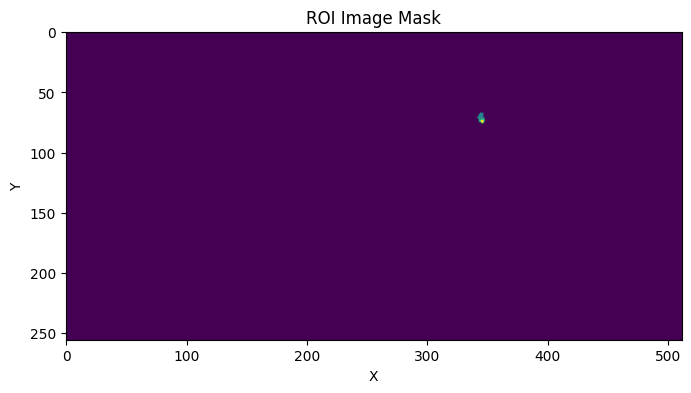

In [62]:
# Plot the image mask for selected ROI 
plt.imshow(image_segmentation.image_mask[ROI])
plt.xlabel('X') 
plt.ylabel('Y') 
plt.title('ROI Image Mask') 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Plot ROI DFF and Image Masks 
    
Building on our DFF frameseries plot, we'll add a plot indicating the spatial location of the selected ROI. Using image mask, we'll identify the contours of the ROI and overlay this with the average projection of the FOV image. 

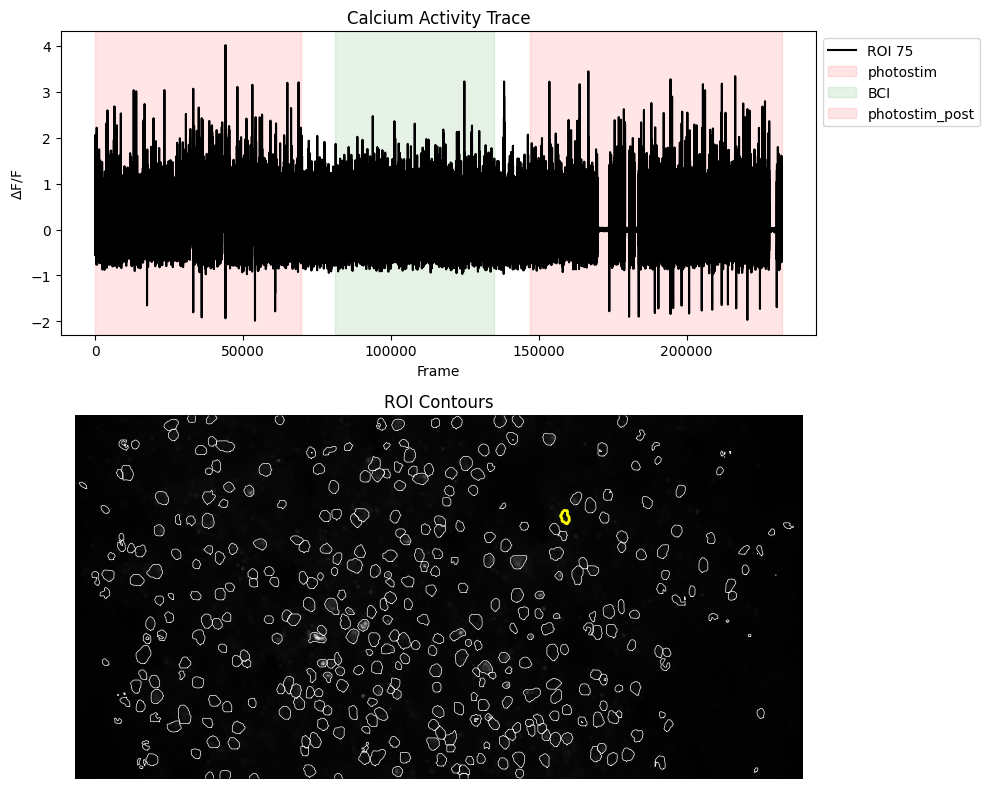

In [63]:
# FOV image data to underlay with image mask contours 
image = nwbfile.processing["processed"].data_interfaces["images"].images["average_projection"].data[:]  # shape: (H, W)

# Figure parameters for vertically stacked plots 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), height_ratios=[1, 1.2])

# Top Plot: ROI DFF 
ax1.plot(dff[:, ROI], label=f'ROI {ROI}', color='black')

# Top Plot: Shaded regions for stimulus epochs 
stim_names = ['photostim','BCI','photostim_post']
colors = ['red','green','red']
for c,stim_name in enumerate(stim_names):
    stim = epoch_table[epoch_table.stim_name==stim_name]
    for j in range(len(stim)):
        ax1.axvspan(xmin=stim.start_frame.iloc[j], xmax=stim.stop_frame.iloc[j], color=colors[c], alpha=0.1, label = stim_name)

ax1.set_ylabel(r'$\Delta$F/F')
ax1.set_xlabel('Frame')
ax1.set_title('Calcium Activity Trace')
ax1.legend(bbox_to_anchor=(1.0, 1.0))

# Bottom plot: Grayscale image with ROI contours 
ax2.imshow(image, cmap='gray')
ax2.set_title('ROI Contours')
ax2.axis('off')

# Overlay ROI contours
for i, mask in enumerate(image_segmentation.image_mask):
    mask_array = np.array(mask)
    contours = measure.find_contours(mask_array, level=0.3)
    for contour in contours:
        color = 'yellow' if i == ROI else 'white'
        linewidth = 2.0 if i == ROI else 0.5
        ax2.plot(contour[:, 1], contour[:, 0], color=color, linewidth=linewidth)

plt.tight_layout()
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Plot conditioned neuron activity and behavior events 

During the BCI behavior epoch, the activity of a single neuron (conditioned neuron) is used to control the movement of a reward lickport. Using information from the bci table and the image segmentation table, let's walk through how to plot the activity of the conditioned neuron aligned to the behavior trial start, lickport movements, and reward times. 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### 1. Match the conditioned neuron to an extracted ROI 

The centroid coordinates of the conditioned neuron are reported in the `conditioned_neuron_x` and `conditioned_neuron_y` columns of the bci table. 

In [64]:
bci[0:5]

,start_time,stop_time,BCI_go_cue,BCI_trial_hit,BCI_lick_L,BCI_reward_time,BCI_threshold_crossing_times,BCI_zaber_steps,BCI_movie_name,start_frame,stop_frame,conditioned_neuron_x,conditioned_neuron_y
id,,,,,,,,,,,,,
0,1393.379034,1398.699698,0.2359,True,"[1.4923000000000002, 1.6292, 1.7521, 1.8716, 1...",1.4923,1.4402,"[0.5722, 0.7792, 0.9072, 0.9882, 1.0602, 1.138...",neuron53_00001.tif,81183,81493,38.166667,44.166667
1,1398.716862,1404.260651,0.2359,True,"[2.2792, 2.4113, 2.5264, 2.6327000000000003, 2...",2.2792,2.1610,"[1.1298, 1.6857, 1.7597, 1.8227, 1.8717, 1.905...",neuron53_00002.tif,81494,81817,38.166667,44.166667
2,1404.277814,1409.546988,0.2359,True,"[1.6492, 1.7715, 1.8798, 1.9924, 2.1023, 2.216...",1.6492,1.5602,"[1.0237, 1.1028, 1.1527, 1.1997, 1.2397, 1.271...",neuron53_00003.tif,81818,82125,38.166667,44.166667
3,1409.564152,1413.923664,0.2359,True,"[0.0222, 0.9292, 1.0387, 1.1985, 1.3162, 1.437...",1.0387,1.0308,"[0.2863, 0.3373, 0.3833, 0.4243, 0.4653, 0.505...",neuron53_00004.tif,82126,82380,38.166667,44.166667
4,1413.940827,1418.471974,0.2359,True,"[1.1341, 1.2667000000000002, 1.404, 1.5119, 1....",1.2667,1.1805,"[0.3632, 0.6332, 0.7482000000000001, 0.8282, 0...",neuron53_00005.tif,82381,82645,38.166667,44.166667


In [65]:
print('Conditioned neuron coordinates:', bci.conditioned_neuron_x[0], bci.conditioned_neuron_y[0])

Conditioned neuron coordinates: 38.166666666666664 44.166666666666664


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Using the image masks, we need to find the ROI that is closest to the conditioned neuron coordinate.     
    
The `get_roi_centroids` function will calculate the centroid for each ROI image mask in the image segmentation table. This finds the x,y indices for each mask and calculates the mean to get the center. 

In [66]:
def get_roi_centroids(image_segmentation):
    centroids = []
    for mask in image_segmentation['image_mask']:
        ys, xs = np.where(mask)
        x = np.mean(xs)
        y = np.mean(ys)
        centroids.append((x, y))
    return np.array(centroids)

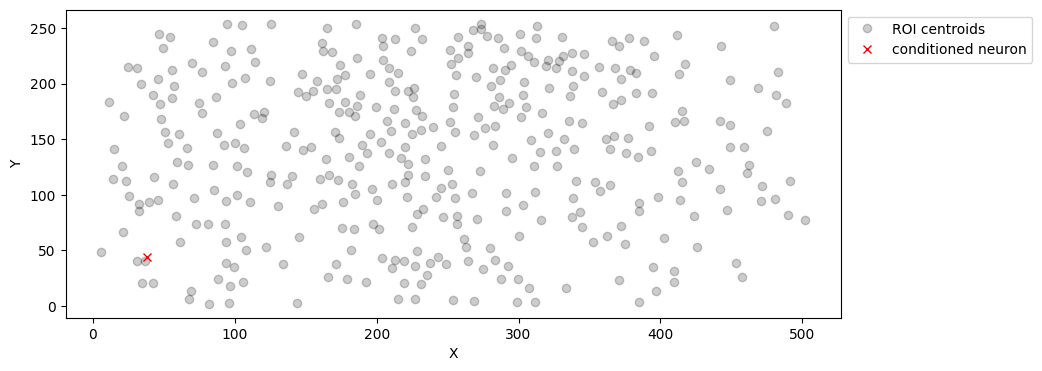

In [67]:
# Calculate centroids for each ROI and add to the image segmentation table 

centroids = get_roi_centroids(image_segmentation)
centroidX = centroids[:, 0]
centroidY = centroids[:, 1]

plt.plot(centroidX, centroidY, 'ko', alpha = 0.2, label = 'ROI centroids')
plt.plot(bci['conditioned_neuron_x'].dropna().iloc[0], bci['conditioned_neuron_y'].dropna().iloc[0], 'rx', alpha = 1, label = 'conditioned neuron')
plt.xlabel('X') 
plt.ylabel('Y')
plt.legend()
plt.legend(bbox_to_anchor=(1.0, 1.0))

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We'll find the extracted ROI centroid that is closest to the conditioned neuron coordinate 

In [68]:
# Grab the first non-null entry
x = bci['conditioned_neuron_x'].dropna().iloc[0]
y = bci['conditioned_neuron_y'].dropna().iloc[0]
conditioned_coord = np.array([x, y])
print("Conditioned neuron coordinate:", conditioned_coord)

# Get centroids and match
centroids = get_roi_centroids(image_segmentation)
roi_coords = np.stack((centroids[:, 0], centroids[:, 1]), axis=1)
conditioned_neuron = np.argmin(np.linalg.norm(roi_coords - conditioned_coord, axis=1)) # Calculate euclidean distance between each ROI coord and conditioend neuron coord, find min 
print(f"Closest ROI is #{conditioned_neuron} at {centroids[conditioned_neuron]}")


Conditioned neuron coordinate: [38.16666667 44.16666667]
Closest ROI is #41 at [36.7721519  40.06329114]


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Convert discrete behavior events into a continuous series 

In [69]:
# Build binary time series

# Initialize timeseries arrays set to 0
n_frames = dff.shape[0]
lickport_steps_ts = np.zeros(n_frames)
rewards_ts = np.zeros(n_frames)
trial_starts_ts = np.zeros(n_frames)

# If behavior event happened, set frame index == 1 
for _, row in bci.iterrows():
    trial_start_f = int(row['start_frame'])

    # Trial start
    if trial_start_f < n_frames:
        trial_starts_ts[trial_start_f] = 1

    # Reward
    rt = row.get('BCI_reward_time', np.nan)
    if not np.isnan(rt):
        reward_f = trial_start_f + int(rt * frame_rate)
        if reward_f < n_frames:
            rewards_ts[reward_f] = 1

    # Zaber steps
    zsteps = row.get('BCI_zaber_steps', [])
    if isinstance(zsteps, (list, np.ndarray)):
        for tstep in zsteps:
            if not np.isnan(tstep):
                step_f = trial_start_f + int(tstep * frame_rate)
                if 0 <= step_f < n_frames:
                    lickport_steps_ts[step_f] = 1


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Plot conditioned neuron activity and behavior events 

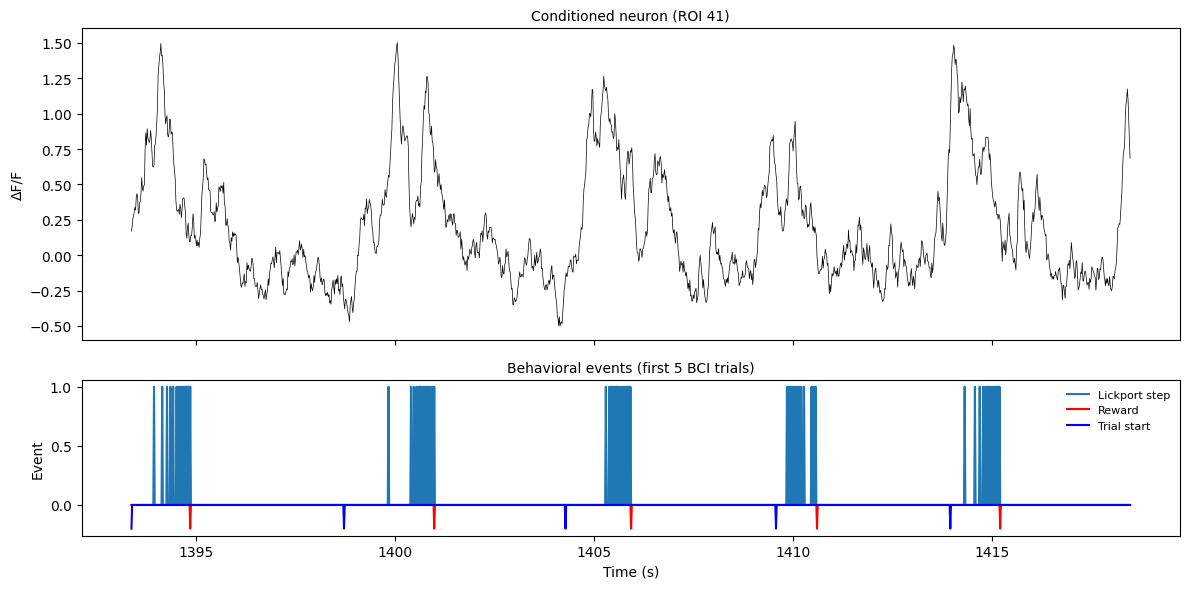

In [70]:
# Set smoothing window size (in frames); set to 0 to disable smoothing
smoothing_window = 10

# Define frame range for first 5 trials
start_f = int(bci['start_frame'].iloc[0])
stop_f  = int(bci['stop_frame'].iloc[4])

# Set bounds for first 5 trials 
frame_range = slice(start_f, stop_f)

# Convert frames to time 
t = np.arange(start_f, stop_f) / frame_rate

# Plot stacked subplots 
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True, height_ratios=[1, 0.5])

# Get conditioned neuron activity over frame_range
trace = dff[frame_range, conditioned_neuron]

# Apply boxcar smoothing if requested
if smoothing_window > 0:
    kernel = np.ones(smoothing_window) / smoothing_window
    trace = np.convolve(trace, kernel, mode='same')

axs[0].plot(t, trace, 'k', linewidth=0.5)

axs[0].set_ylabel('ΔF/F')
axs[0].set_title(f'Conditioned neuron (ROI {conditioned_neuron})', fontsize=10)

# Plot behavioral events 
axs[1].plot(t, lickport_steps_ts[frame_range], label='Lickport step')
axs[1].plot(t, -rewards_ts[frame_range]/5, 'r', label='Reward')
axs[1].plot(t, -trial_starts_ts[frame_range]/5, 'b', label='Trial start')
axs[1].legend(fontsize=8, loc='upper right', frameon=False)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Event')
axs[1].set_title('Behavioral events (first 5 BCI trials)', fontsize=10)

plt.tight_layout()
plt.show()


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Define functions for identifying roi locations, photostim. response amplitude, and distance from each roi to each photostimulation target

In [26]:
# Set default matplotlib plotting style from external config
from plot_config import set_default_plot_style
set_default_plot_style()

# Microns per pixel (scale for spatial calculations)
umPerPix = 1.7755681818181817

In [27]:
# ----------------------------
# Utility Functions
# ----------------------------
def stim_amp_nwb(dff, photostim, pre_frames=5, post_frames=4, response_start=16, response_end=20):
    """Calculate response amplitude and trial-averaged traces around photostim events."""
    stim_frames = photostim[photostim.stim_name == "photostim"].start_frame.values
    n_rois = dff.shape[1]
    valid_trials = []

    # Exclude stim events too close to start or end
    for frame in stim_frames:
        if frame - pre_frames < 0 or frame + response_end >= dff.shape[0]:
            continue
        valid_trials.append(frame)

    favg = np.zeros((response_end, n_rois, len(valid_trials)))

    # Loop over valid trials and compute ΔF/F normalized by pre/post baseline
    for i, frame in enumerate(valid_trials):
        trial_window = dff[frame : frame + response_end, :]
        baseline = np.nanmean(dff[frame + pre_frames : frame + post_frames, :], axis=0)
        norm = (trial_window - baseline) / baseline
        favg[:, :, i] = norm

    # Amplitude: post-stim mean minus pre-stim mean
    amp = np.nanmean(favg[response_start:response_end, :, :], axis=0) - np.nanmean(favg[pre_frames:post_frames, :, :], axis=0)

    return amp, favg

def compute_groupwise_stim_distance(centroidX, centroidY, photostim):
    """Compute distance from each neuron to each stimulation group center."""
    roi_coords = np.stack((centroidX, centroidY), axis=1)
    group_table = photostim[photostim.stim_name == 'photostim']
    groups = group_table.groupby('group_index')[['laser_stim_x', 'laser_stim_y']].mean()
    stim_coords = groups.values

    n_rois, n_groups = roi_coords.shape[0], stim_coords.shape[0]
    stimDist_group = np.zeros((n_rois, n_groups))

    for g in range(n_groups):
        dx = roi_coords[:, 0] - stim_coords[g, 0]
        dy = roi_coords[:, 1] - stim_coords[g, 1]
        stimDist_group[:, g] = np.sqrt(dx**2 + dy**2)

    return stimDist_group

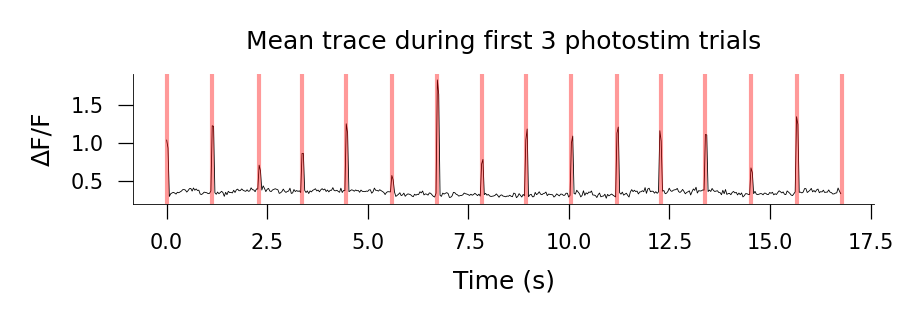

In [28]:
# Get first 3 photostim events
events = photostim[photostim.stim_name == 'photostim'].iloc[:16]
stim_frames = events['start_frame'].values

# Define time window: 2s before first stim to 3s after last
start_f = max(0, stim_frames[0] - int(.2 * frame_rate))
stop_f  = min(len(dff), stim_frames[-1] + int(0 * frame_rate))
t = np.arange(start_f, stop_f) / frame_rate

# Plot average trace during this window
plt.figure(figsize=(3, 1))
trace = np.nanmean(dff[start_f:stop_f], axis=1)
plt.plot(t, trace, 'k', linewidth=0.2)

# Overlay stim event markers
for f in stim_frames:
    if start_f <= f <= stop_f:
        plt.axvline(f / frame_rate, color='r', linestyle='-', alpha=0.4,linewidth=1)

plt.xlabel('Time (s)')
plt.ylabel('ΔF/F')
plt.title('Mean trace during first 3 photostim trials')
plt.tight_layout()
plt.show()

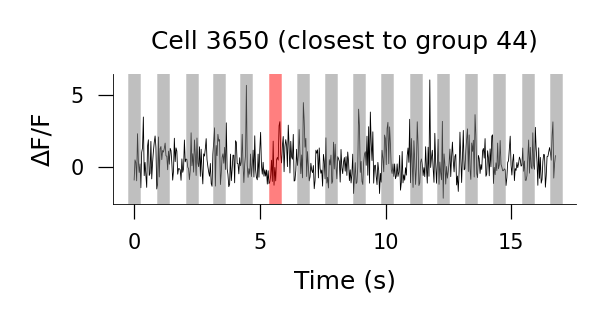

In [29]:
trial_of_interest = 5
# Compute ROI coordinates
centroids = get_roi_centroids(image_segmentation)  # returns (n_rois, 2)
centroidX = centroids[:, 0]
centroidY = centroids[:, 1]
roi_coords = np.stack((centroidX, centroidY), axis=1)  # (n_neurons, 2)

# Get early events
events = photostim[photostim.stim_name == 'photostim'].iloc[:16]
stim_frames = events['start_frame'].values
groups = events['group_index'].values

# Compute group coordinates (mean x/y per group)
group_means = photostim[photostim.stim_name == 'photostim'] \
    .groupby('group_index')[['laser_stim_x', 'laser_stim_y']].mean()

# Align group order to those used in this block
stim_coords = group_means.loc[groups].values  # shape: (n_groups, 2)

# Compute stimDist manually
stimDist = np.linalg.norm(roi_coords[:, None, :] - stim_coords[None, :, :], axis=2)  # (n_rois, n_groups)

# Trial of interest
group = groups[trial_of_interest] - 1  # MATLAB to Python indexing
cell = np.argmin(stimDist[:, trial_of_interest])  # closest to that group's stim coords

# Time window
start_f = max(0, stim_frames[0] - int(0.2 * frame_rate))
stop_f  = min(len(dff), stim_frames[-1] + int(0 * frame_rate))
t = np.arange(start_f, stop_f) / frame_rate

# Plot
plt.figure(figsize=(2, 1))
trace = dff[start_f:stop_f, cell]
plt.plot(t, trace, 'k', linewidth=0.2)

for i, f in enumerate(stim_frames):
    if start_f <= f <= stop_f:
        color = 'gray'
        if i == trial_of_interest:
            color = 'r'
        plt.axvline(f / frame_rate, color=color, linestyle='-', alpha=0.5, linewidth=3)

plt.xlabel('Time (s)')
plt.ylabel('ΔF/F')
plt.title(f'Cell {cell} (closest to group {group})')
plt.tight_layout()
plt.show()


In [30]:
trial_of_interest = 5
photostim[photostim.stim_name == 'photostim']['laser_stim_x'][5]

np.float64(313.4249999928889)

In [31]:
roi

NameError: name 'roi' is not defined

In [ ]:
# Define time window: from 0.2s before first stim to 0s after last stim
pre_f = int(0.2 * frame_rate)
post_f = 0  # if you want to extend this, set to int(n seconds * frame_rate)

# Extract events
events = photostim[photostim.stim_name == 'photostim'].iloc[:46]
stim_frames = events['start_frame'].values
groups = events['group_index'].values

# ROI coordinates
centroids = get_roi_centroids(image_segmentation)
roi_coords = np.stack((centroids[:, 0], centroids[:, 1]), axis=1)

# Group stim coordinates
group_means = photostim[photostim.stim_name == 'photostim'] \
    .groupby('group_index')[['laser_stim_x', 'laser_stim_y']].mean()
stim_coords = group_means.loc[groups].values

# Compute stimDist
stimDist = np.linalg.norm(roi_coords[:, None, :] - stim_coords[None, :, :], axis=2)

# Determine which cell was targeted on each trial
target_cells = [np.argmin(stimDist[:, i]) for i in range(len(groups))]

# Shared time window (absolute time)
start_f = max(0, stim_frames[0] - pre_f)
stop_f = min(len(dff), stim_frames[-1] + post_f)
t = np.arange(start_f, stop_f) / frame_rate

# Extract traces for each targeted cell over this window
traces = np.array([dff[start_f:stop_f, cell] for cell in target_cells])

# Plot heatmap
plt.figure(figsize=(4, 2))
plt.imshow(traces, aspect='auto', cmap='seismic', vmin=-10, vmax=10,
           extent=[t[0], t[-1], 1, len(traces)],interpolation = 'none')
plt.xlabel('Time (s)')
plt.ylabel('Trial')
plt.title('Targeted cell traces')
plt.colorbar(label='ΔF/F')
plt.tight_layout()
plt.show()


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; ">

#### Questions to explore further:
 
* How does connectivity change across the photostimulation periods? Does it change with the BCI task? 
    
* Does the conditioned neuron's connectivity change after the BCI task?
    
* Do differences in the transgenic lines or injected viruses impact connectivity and photostimulation measurements? 
    
* Do non-conditioned neurons change activity during the BCI task? 

